<center><img src="monai.png"/></center>

<p style="text-align: center">Welcome to the MONAI bootcamp!</p>
<p style="text-align: center">This notebook will introduce you MONAI Bundles, the MONAI Model Zoo, and how to visualize your images using ITK Widgets.</center>



### Using Google Colab

This notebook has the pip command for installing MONAI and will be added to any subsequent notebook.

**Enabling GPU Support**

To use GPU resources through Colab, change the runtime to GPU:

1. From the **"Runtime"** menu select **"Change Runtime Type"**
2. Choose **"GPU"** from the drop-down menu
3. Click **"SAVE"**

This will reset the notebook and probably ask you if you are a robot (these instructions assume you are not). Running



### Verify GPU Access

Running **!nvidia-smi** in a cell will verify this has worked and show you what kind of hardware you have access to.    

In [1]:
!nvidia-smi

Tue Apr 11 17:28:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0   207W / 400W |   2284MiB / 81251MiB |     81%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

**Required Packages for Colab Execution**

Execute the following cell to install MONAI the first time a colab notebook is run:

In [2]:
#!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm, fire]==1.1.0"

## MONAI Bundle

The objective of the MONAI bundle is to define a packaged model which includes the critical information necessary to allow users and programs to understand how the model is used and what purpose it is for. A bundle includes the stored weights of a single network as a pickled state dictionary plus optionally a Torchscript object and/or an ONNX object. Additional JSON files are included to store metadata about the model, information for constructing training, inference, and post-processing transform sequences, plain-text description, legal information, and other data the model creator wishes to include.

The key benefits of a bundle are to define the model package and support building Python-based workflows via structured configurations:

- A self-contained model package includes all the necessary information.
- A structured config can be used to easily reconstruct or prototype deep learning workflows.
- Config files can provide good readability and usability by separating parameter settings from the Python code.
- Config files can describe flexible workflow and components, allows for different low-level Python implementations
- Learning paradigms at a higher level such as federated learning and AutoML can be decoupled from the component details.


The key features support config to python conversion, hybrid programming, and lazy instantiation in the python program.

- Build a full program from structured config and execute from CLI
- Read config / metadata from JSON / YAML files with override at runtime
- Refer to other python object in the config
- Macro text replacement with content in the same / other config files
- Verify metadata format based on predefined schema
- Verify network input / output with fake data
- Export to Torchscript


A typical bundle example can include:

```
  ModelName
  ┣━ configs
  ┃  ┗━ metadata.json
  ┣━ models
  ┃  ┣━ model.pt
  ┃  ┣━ *model.ts
  ┃  ┗━ *model.onnx
  ┗━ docs
     ┣━ *README.md
     ┗━ *license.txt
```

### A basic example

Components as part of a workflow can be specified using `JSON` or `YAML` syntax, for example, a network architecture definition could be stored in a `demo_config.json` file with the following content:

```json
{
  "demo_net": {
    "_target_": "monai.networks.nets.BasicUNet",
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "features": [16, 16, 32, 32, 64, 64]
  }
}
```

or alternatively, in `YAML` format (`demo_config.yaml`):

```yaml
demo_net:
  _target_: monai.networks.nets.BasicUNet
  spatial_dims: 3
  in_channels: 1
  out_channels: 2
  features: [16, 16, 32, 32, 64, 64]
```

The configuration parser can instantiate the component as a Python object:

```python
from monai.bundle import ConfigParser
config = ConfigParser()
config.read_config("demo_config.json")
net = config.get_parsed_content("demo_net", instantiate=True)
BasicUNet features: (16, 16, 32, 32, 64, 64).
print(type(net))
<class 'monai.networks.nets.basic_unet.BasicUNet'>
```

or additionally, tune the input parameters then instantiate the component:

```python
config["demo_net"]["features"] = [32, 32, 32, 64, 64, 64]
net = config.get_parsed_content("demo_net", instantiate=True)
BasicUNet features: (32, 32, 32, 64, 64, 64).
```

### Syntax examples explained

A few characters and keywords are interpreted beyond the plain texts, here are examples of the syntax:

To reference Python objects in configurations

```
"@preprocessing#transforms#keys"
```

Description: `@` character indicates a reference to another configuration value defined at `preprocessing#transforms#keys`. Where `#` indicates a sub-structure of this configuration file.

```
"@preprocessing#1"
```

Description: `1` is referencing as an integer, which is used to index (zero-based indexing) the `preprocessing` sub-structure.

To evaluate as Python expressions

```
"$print(42)"
```

Description: `$` is a special character to indicate evaluating `print(42)` at runtime.

```
"$[i for i in @datalist]"
```

Description: Create a list at runtime using the values in datalist as input.

```
"$from torchvision.models import resnet18"
```

Description: `$` followed by an import statement is handled slightly differently from the Python expressions. The imported module `resnet18` will be available as a global variable to the other configuration sections. This is to simplify the use of external modules in the configuration.

To textually replace configuration elements

```
"%demo_config.json#demo_net#in_channels"
```

Description: `%` character indicates a macro to replace the current configuration element with the texts at `demo_net#in_channels` in the `demo_config.json` file. The replacement is done before instantiating or evaluating the components.

Instantiate a Python object

```json
{
  "demo_name":{
    "_target_": "my.python.module.Class",
    "args1": "string",
    "args2": 42}
}
```

Description: This dictionary defines an object with a reference name `demo_name`, with an instantiable type specified at `_target_` and with input arguments `args1` and `args2`. This dictionary will be instantiated as a Pytorch object at runtime.

`_target_` is a required key by monai bundle syntax for the Python object name. `args1` and `args2` should be compatible with the Python object to instantiate.

### The command line interface

In addition to the Pythonic APIs, a few command line interfaces (CLI) are provided to interact with the bundle. The primary usage is:

```bash
python -m monai.bundle COMMANDS
```

where `COMMANDS` is one of the following: `run`, `verify_metadata`, `ckpt_export`, … (please see `python -m monai.bundle --help` for a list of available options).

The CLI supports flexible use cases, such as overriding configs at runtime and predefining arguments in a file. To display a usage page for a command, for example run:

```bash
python -m monai.bundle run -- --help
```

The support is provided by Python Fire, please make sure the optional dependency is installed, for example, using `pip install monai[fire]` or `pip install fire`. Details on the CLI argument parsing is provided in the Python Fire Guide.

### MONAI Model Zoo

https://monai.io/model-zoo

MONAI Model Zoo is a curated library of pre-trained models, allowing data scientists and clinical researchers to jumpstart AI development. Both NVIDIA and partners across KCL, Charite, Warwick, Vanderbilt, and Mayo Clinic have contributed pre-trained models to MONAI’s open-source community. Over 15 pre-trained models are included: CT, MR, Pathology, and Endoscopy that cover segmentation, classification, registration and GAN based models. They are packaged as MONAI Bundles that can be accessed within a single click, establishing a common standard for reproducible research & collaboration.


The MONAI Bundle format defines portable describes of deep learning models. A bundle includes the critical information necessary during a model development life cycle and allows users and programs to understand the purpose and usage of the models.

### Spleen Segmentation Bundle Example

We're going to use a the Spleen Segmentation Model and the Spleen Dataset from the Medical Segmentation Decathalon to showcase an example of how to use the Model Zoo and Bundle.

#### Setup imports

In [3]:
import os
import monai
import tempfile
from monai.apps import download_and_extract
from monai.bundle import ConfigParser
from monai.data import decollate_batch
from monai.handlers import MLFlowHandler
from monai.config import print_config
from monai.visualize.utils import blend_images

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage.measure import marching_cubes
import numpy as np

import torch

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.0.1
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.12.1
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#### Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/scratch/local/61588599/tmpa06cq5_6


#### Download spleen dataset

Downloads and extracts the dataset. The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

/scratch/local/61588599/tmpa06cq5_6/Task09_Spleen


Task09_Spleen.tar: 1.50GB [01:18, 20.6MB/s]                               

2023-04-11 17:29:29,006 - INFO - Downloaded: /scratch/local/61588599/tmpa06cq5_6/Task09_Spleen.tar


2023-04-11 17:29:31,607 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-04-11 17:29:31,607 - INFO - Writing into directory: /scratch/local/61588599/tmpa06cq5_6.


We're going to remove some of the data since this is just an example and depending on this system it might not be able to load all of the data into memory.

In [6]:
!find {data_dir}/imagesTs/spleen_* -type f | sort -zR | head -10 | tr '\n' '\0' | xargs -0 rm

In [36]:
!ls {data_dir}/imagesTs

spleen_42.nii.gz  spleen_50.nii.gz  spleen_55.nii.gz  spleen_7.nii.gz
spleen_43.nii.gz  spleen_51.nii.gz  spleen_57.nii.gz
spleen_48.nii.gz  spleen_54.nii.gz  spleen_58.nii.gz


#### Download spleen segmentation bundle

We can utilize the MONAI Bundle commands to download any of the models available on the MONAI Model Zoo.

In [7]:
monai.bundle.download(name="spleen_ct_segmentation", version="0.3.7", bundle_dir="./zoo_dir")

2023-04-11 17:29:33,130 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-04-11 17:29:33,130 - INFO - > name: 'spleen_ct_segmentation'
2023-04-11 17:29:33,131 - INFO - > version: '0.3.7'
2023-04-11 17:29:33,133 - INFO - > bundle_dir: './zoo_dir'
2023-04-11 17:29:33,134 - INFO - > source: 'github'
2023-04-11 17:29:33,134 - INFO - > repo: 'Project-MONAI/model-zoo/hosting_storage_v1'
2023-04-11 17:29:33,135 - INFO - > progress: True
2023-04-11 17:29:33,135 - INFO - ---




spleen_ct_segmentation_v0.3.7.zip: 33.9MB [00:00, 49.2MB/s]                            

2023-04-11 17:29:33,940 - INFO - Downloaded: zoo_dir/spleen_ct_segmentation_v0.3.7.zip
2023-04-11 17:29:33,941 - INFO - Expected md5 is None, skip md5 check for file zoo_dir/spleen_ct_segmentation_v0.3.7.zip.
2023-04-11 17:29:33,942 - INFO - Writing into directory: zoo_dir.


#### Run Inference on the Spleen Bundle

In [8]:
!python -m monai.bundle run evaluating \
    --meta_file "./zoo_dir/spleen_ct_segmentation/configs/metadata.json" \
    --config_file "./zoo_dir/spleen_ct_segmentation/configs/inference.json" \
    --logging_file "./zoo_dir/spleen_ct_segmentation/configs/logging.conf" \
    --dataset_dir "{data_dir}" \
    --bundle_root "./zoo_dir/spleen_ct_segmentation"

2023-04-11 17:29:45,299 - INFO - --- input summary of monai.bundle.scripts.run ---
2023-04-11 17:29:45,299 - INFO - > runner_id: 'evaluating'
2023-04-11 17:29:45,299 - INFO - > meta_file: './zoo_dir/spleen_ct_segmentation/configs/metadata.json'
2023-04-11 17:29:45,299 - INFO - > config_file: './zoo_dir/spleen_ct_segmentation/configs/inference.json'
2023-04-11 17:29:45,299 - INFO - > logging_file: './zoo_dir/spleen_ct_segmentation/configs/logging.conf'
2023-04-11 17:29:45,299 - INFO - > dataset_dir: '/scratch/local/61588599/tmpa06cq5_6/Task09_Spleen'
2023-04-11 17:29:45,299 - INFO - > bundle_root: './zoo_dir/spleen_ct_segmentation'
2023-04-11 17:29:45,299 - INFO - ---


2023-04-11 17:29:45,300 - INFO - set logging properties based on config: ./zoo_dir/spleen_ct_segmentation/configs/logging.conf.
2023-04-11 17:29:45,666 - ignite.engine.engine.SupervisedEvaluator - INFO - Engine run resuming from iteration 0, epoch 0 until 1 epochs
2023-04-11 17:29:45,690 - ignite.engine.engine.Supervised

### Full list of commands

#### Execute training:

```
python -m monai.bundle run training --meta_file configs/metadata.json --config_file configs/train.json --logging_file configs/logging.conf
```

#### Override the `train` config to execute multi-GPU training:

```
torchrun --standalone --nnodes=1 --nproc_per_node=2 -m monai.bundle run training --meta_file configs/metadata.json --config_file "['configs/train.json','configs/multi_gpu_train.json']" --logging_file configs/logging.conf
```

Please note that the distributed training-related options depend on the actual running environment; thus, users may need to remove `--standalone`, modify `--nnodes`, or do some other necessary changes according to the machine used. For more details, please refer to [pytorch's official tutorial](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html).

#### Override the `train` config to execute evaluation with the trained model:

```
python -m monai.bundle run evaluating --meta_file configs/metadata.json --config_file "['configs/train.json','configs/evaluate.json']" --logging_file configs/logging.conf
```

#### Override the `train` config and `evaluate` config to execute multi-GPU evaluation:

```
torchrun --standalone --nnodes=1 --nproc_per_node=2 -m monai.bundle run evaluating --meta_file configs/metadata.json --config_file "['configs/train.json','configs/evaluate.json','configs/multi_gpu_evaluate.json']" --logging_file configs/logging.conf
```

#### Execute inference:

```
python -m monai.bundle run evaluating --meta_file configs/metadata.json --config_file configs/inference.json --logging_file configs/logging.conf
```

### MONAI Bundle Hybrid Programming

We're going to utilize the Hybrid Programming technique to load all of the components that we'll need to load and run inference on the network.  We'll then vizualize the results!

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(device)

cuda:0


In [21]:
!pwd

/home/hju/AI4HEALTH_workshop/monai-bootcamp/MONAICore


In [22]:
print(output_dir)

/home/hju/AI4HEALTH_workshop/monai-bootcamp/MONAICore/monai_results


In [12]:
# The model's config file dynamically generates the functions needed to process new data.

# Define our local system and filesystem.
output_dir = os.path.abspath("./monai_results")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parse the variables in the config file.
model_config_file = os.path.join("./zoo_dir", "spleen_ct_segmentation", "configs", "inference.json")
model_config = ConfigParser()
model_config.read_config(model_config_file)

# Update the confir variables to match our filesystem.
model_config["bundle_root"] = "./zoo_dir"
model_config["output_dir"] = output_dir
model_config["dataset_dir"] = data_dir

# Identify which version of the model we want to load (each version is a
#    "checkpoint").  For most models, the "best" checkpoint is called "model.pt"
#    and it is stored in the models subdir.
checkpoint = os.path.join("./zoo_dir", "spleen_ct_segmentation", "models", "model.pt")

# Ask the config file to generate the functions needed to process new data.
#    These functions are adapted to our system by the config variables we
#    modified above.  The order of first defining variables and then creating the
#    functions is critical.
preprocessing = model_config.get_parsed_content("preprocessing")
model = model_config.get_parsed_content("network").to(device)
inferer = model_config.get_parsed_content("inferer")
postprocessing = model_config.get_parsed_content("postprocessing")
dataloader = model_config.get_parsed_content("dataloader")

Here we'll load the Model State and make sure that eval mode is enabled.  We can then fetch data from the data loader and run our inference method.

In [13]:
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

d = next(iter(dataloader))   
images = d["image"].to(device)
d["pred"] = inferer(images, network=model)

In [34]:
d['image'].shape

(1, 1, 226, 226, 214)

In [14]:
orig_img = d['image'][0]
pred_img = d['pred'].argmax(1).cpu()
map_image = orig_img + pred_img
print(map_image.shape)

(1, 226, 226, 214)


Now that we have the results, we can visualize the results so we can see that we are correctly getting our segmentation mask.

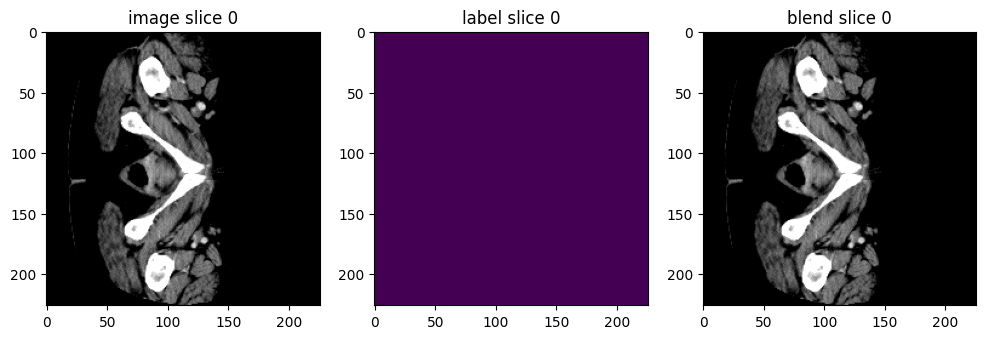

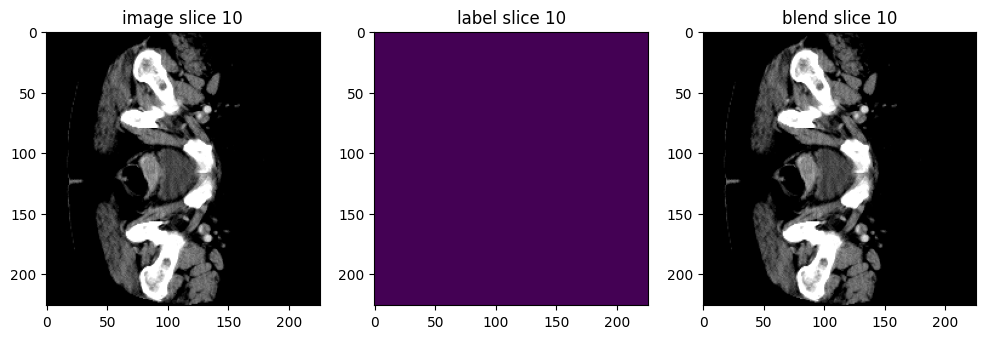

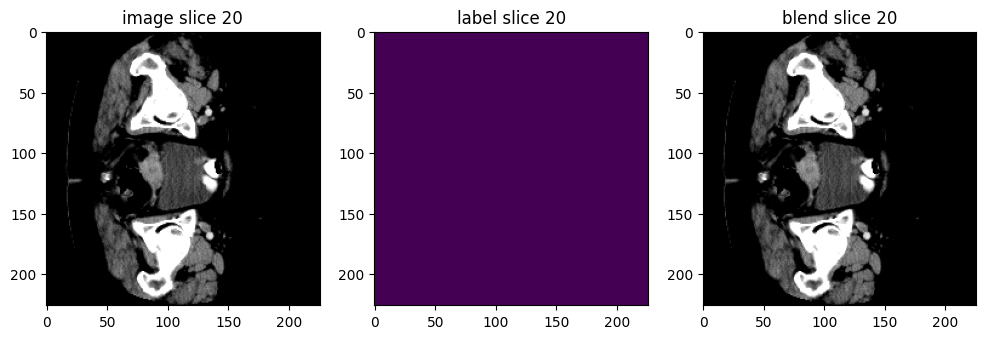

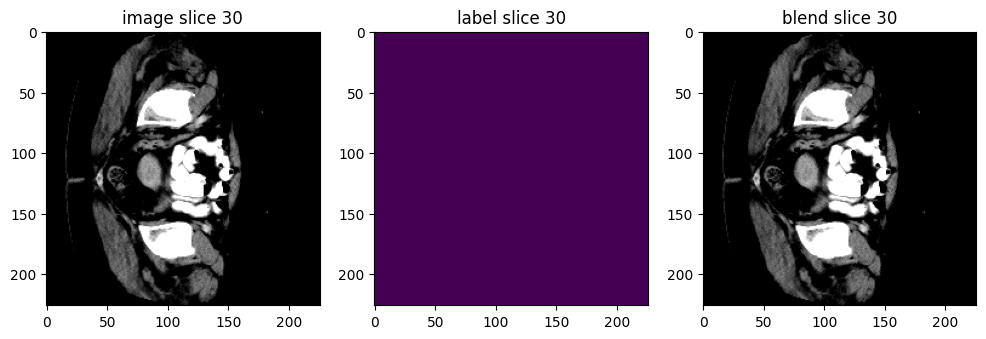

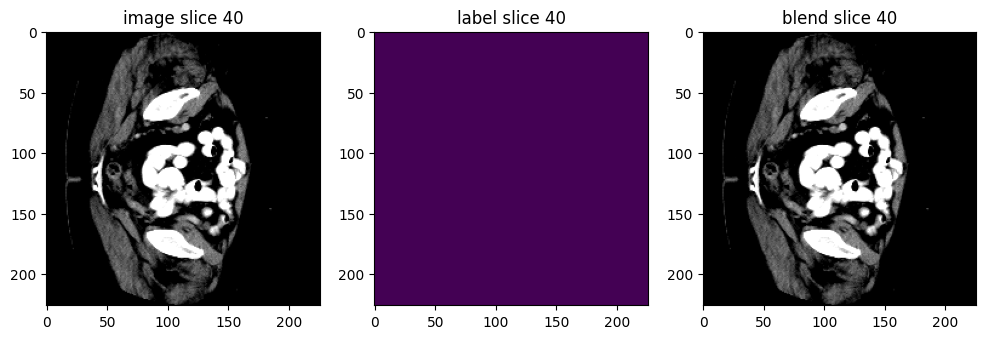

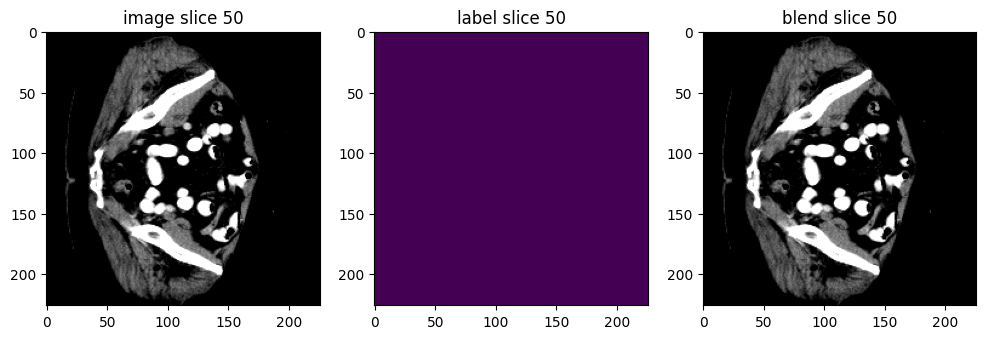

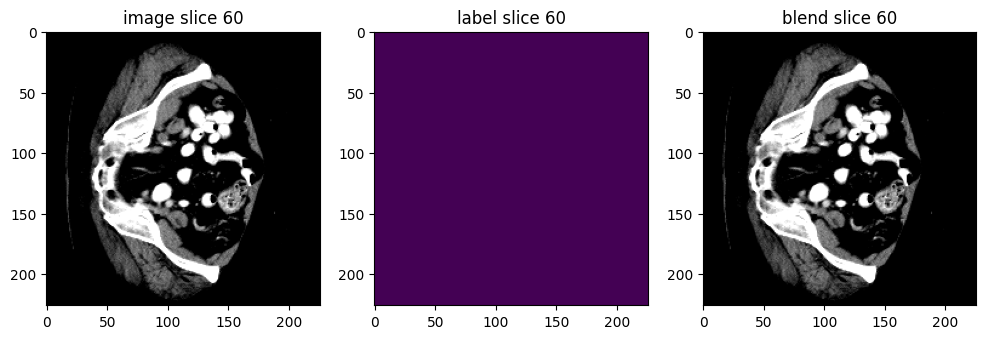

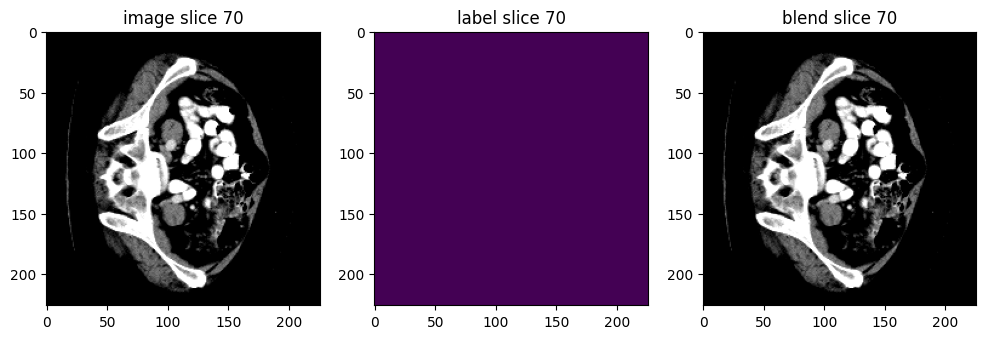

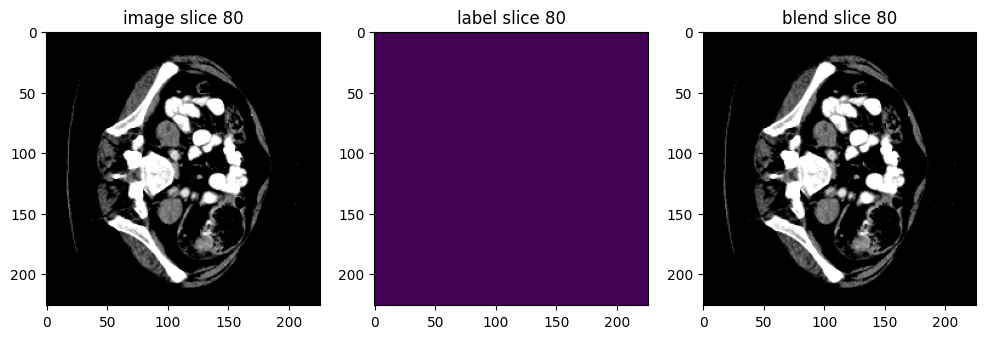

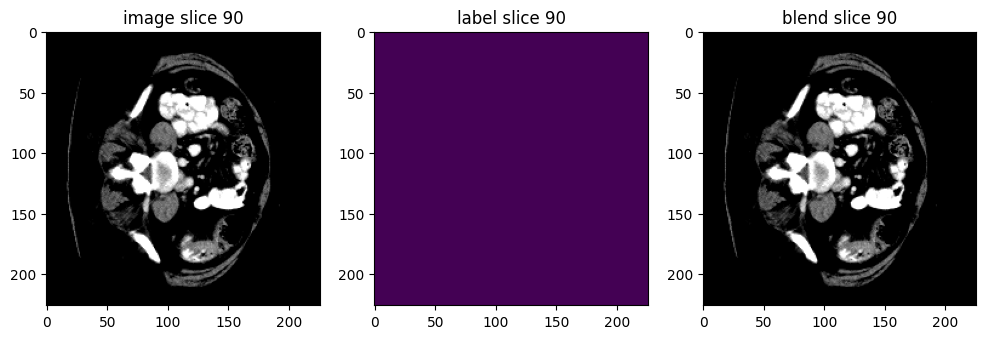

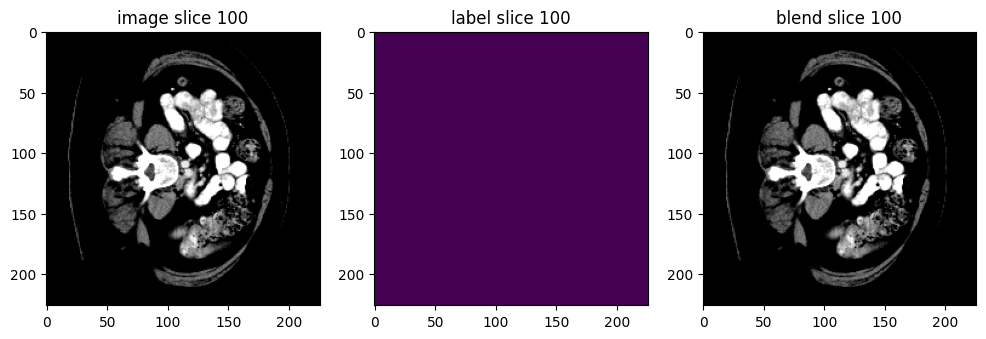

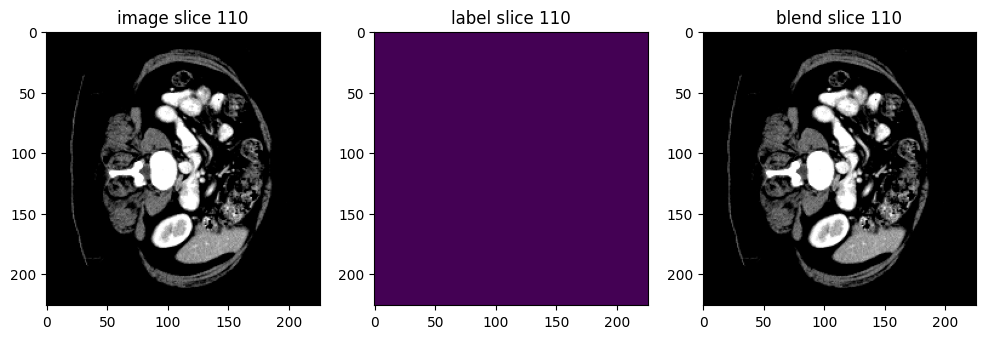

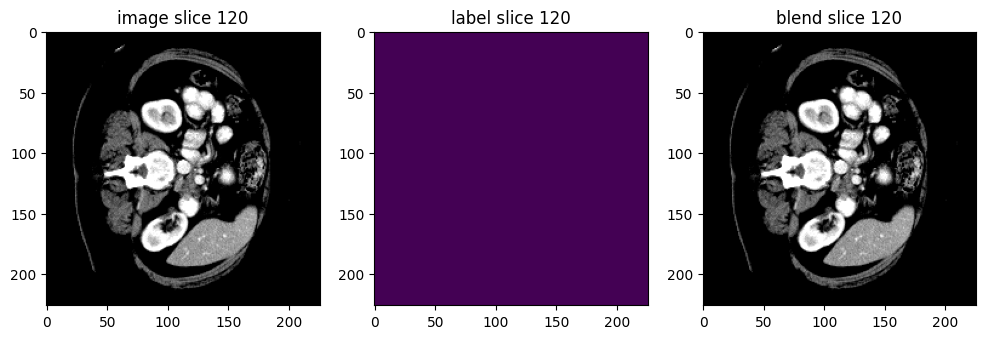

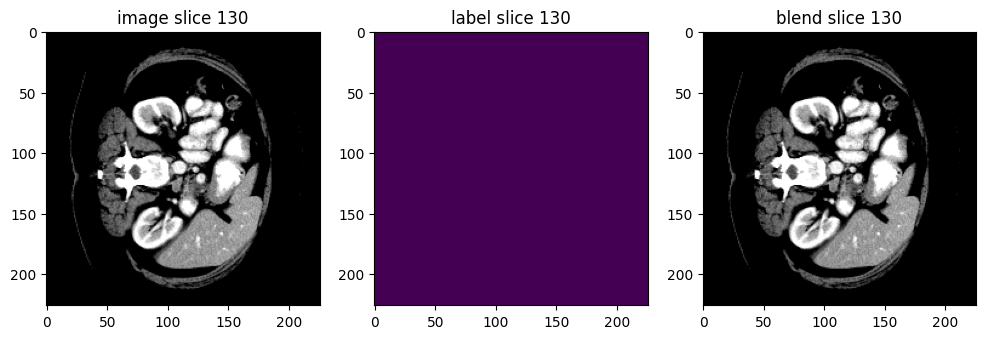

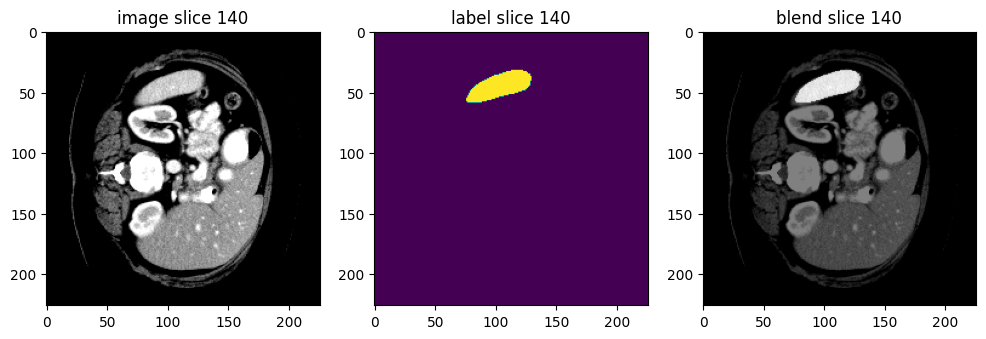

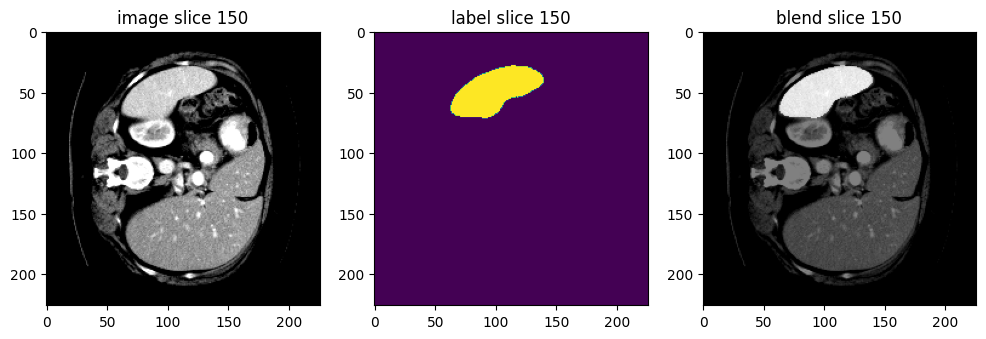

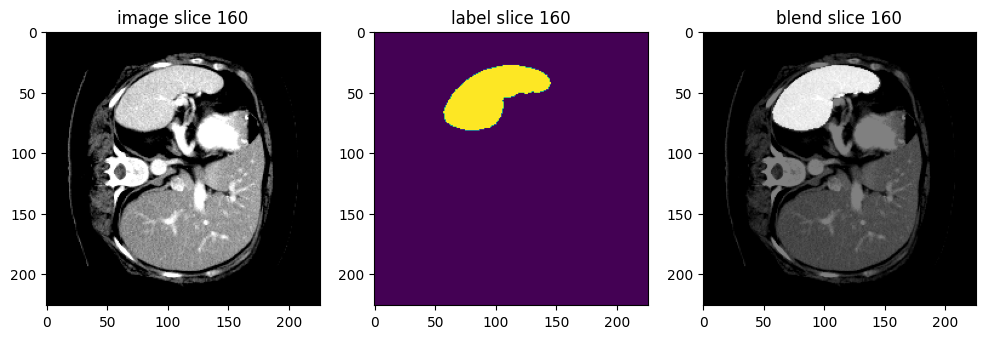

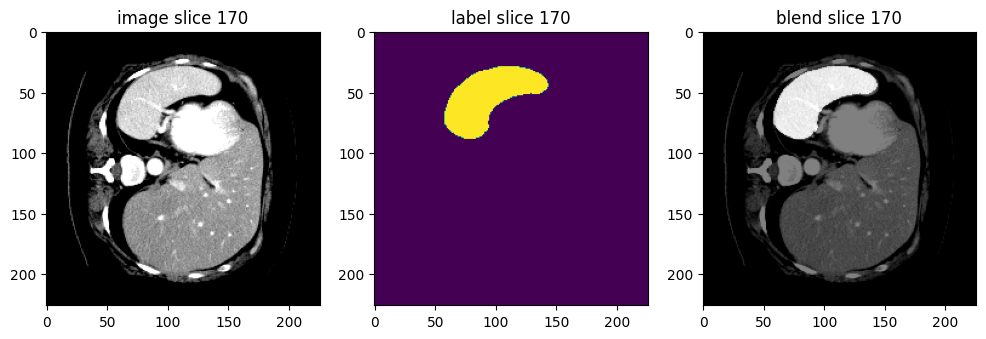

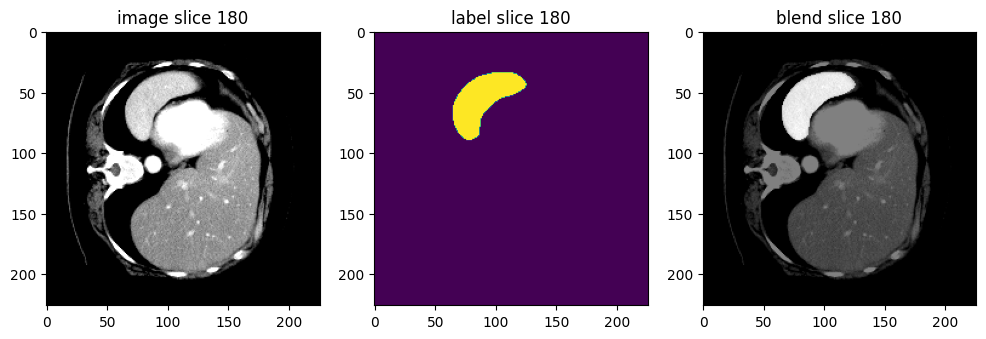

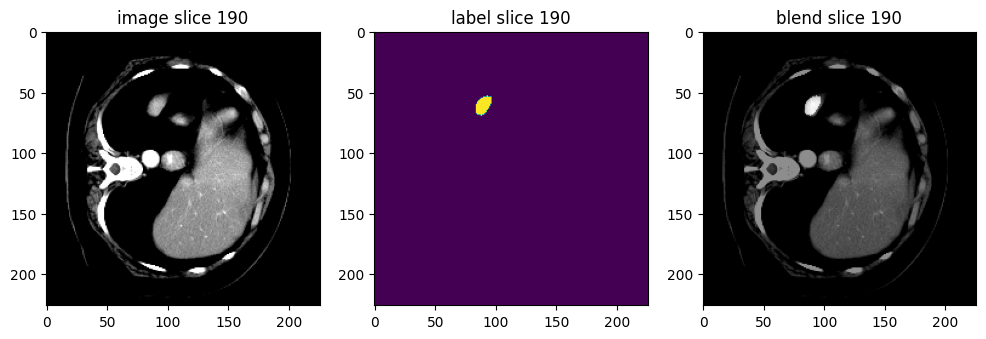

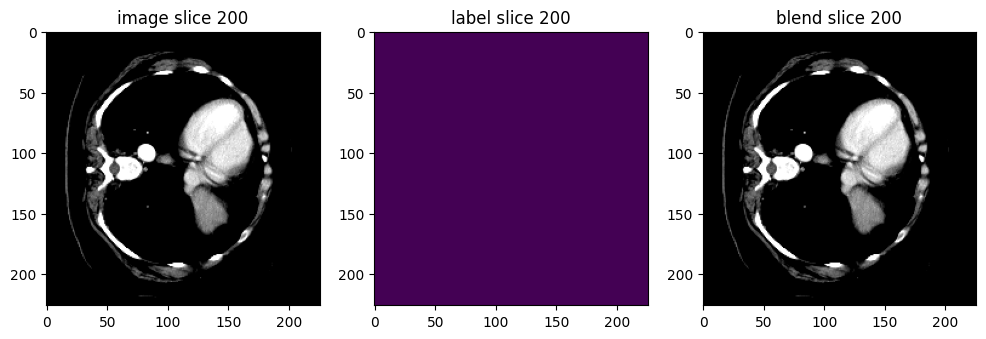

In [15]:
slices = map_image.shape[-1]
for i in range(0, int(slices / 10)):
    # plot the slice 30 - 60 of image, label and blend result
    slice_index = 10 * i
    plt.figure("blend image and label", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(d['image'][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label slice {slice_index}")
    plt.imshow(pred_img[0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    map_image = (d['image'][0] + d['pred'].argmax(1).cpu())
    plt.imshow(map_image[0, :, :, slice_index], cmap="gray")
    plt.show()